In [1]:
#   useful modules
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten,Dense,Lambda,Dropout
from keras.layers.convolutional import Convolution2D,Cropping2D, MaxPooling2D
from keras.layers.core import SpatialDropout2D
from keras.callbacks import ModelCheckpoint
import matplotlib.image as mpimg
from keras.backend import tf as ktf
from keras.utils.visualize_util import plot 

Using TensorFlow backend.


In [2]:
#   read in the csv file and save the data inside variable lines;
lines = []
file_dic = "./data/"
with open(file_dic + "driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
print("Shape of read images dataset", np.shape(lines))

Shape of read images dataset (8295, 7)


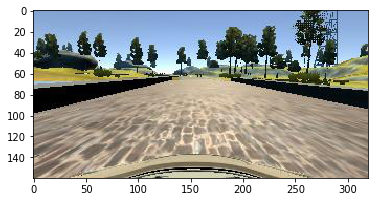

In [33]:
%matplotlib inline
image_path = "./data/IMG/center_2016_12_01_13_30_48_287.jpg"
# print('This image is:', type(image), 'with dimensions:', image.shape)
image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

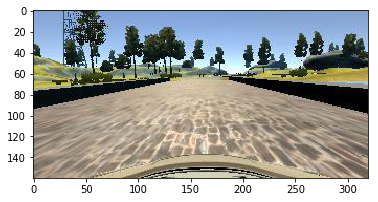

In [4]:
image = cv2.flip(image, 1)
plt.imshow(image)

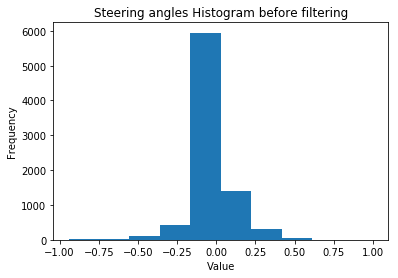

In [31]:
angles = []
samples = []
center_counter = 0
for sample in lines:
    center_value = float(sample[3])
    angles.append(center_value)
    samples.append(sample)
    
plt.hist(angles)
plt.title("Steering angles Histogram before filtering")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.gcf()
plt.show()

In [32]:
center_counter = 0
for sample in lines:
    center_value = float(sample[3])
    if center_value > 0.2 and center_value < -0:
        angles.append(center_value)
        samples.append(sample)
    if center_value <= 0.2 or center_value >= 0:
        if center_counter >= 4:
            angles.append(center_value)
            samples.append(sample)
            center_counter = 0
        center_counter += 1

print("Shape of read non-redundant images dataset", np.shape(samples))

Shape of read non-redundant images dataset (10368, 7)


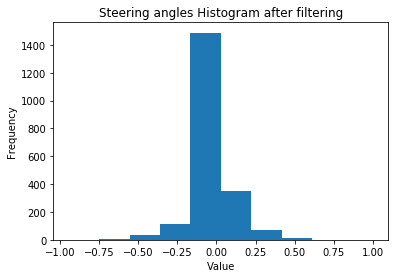

In [27]:
plt.hist(angles)
plt.title("Steering angles Histogram after filtering")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.gcf()
plt.show()

In [6]:
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [7]:
def generator(samples, batch_size=32):
    correction = 0.25
    sample_count = len(samples)
    while True:
        shuffle(samples)
#        capsule the data package
        for offset in range(0, sample_count, batch_size):
            batch_samples = samples[offset:offset + batch_size]
            images  = []
            angles = []
            X_train = []
#            handling augmented images and angles
            for batch_sample in batch_samples:
                center_angle = float(batch_sample[3])
                flipped_center_angle = -1.0 * (center_angle)
#                introduce image from 3 cameras
                for i in range(3):
                    image_addr = batch_sample[i]
                    image_path = image_addr.split('/')[-1]
                    image_path = "./data/IMG/" + image_path
                    image = cv2.imread(image_path)
#                    transforming colorspace
                    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#                     image = image[70:140,10:310]
#                     image = cv2.resize(image,(24,24))
                    images.append(image)
#                    flip the image to augment the samples
                    images.append(cv2.flip(image, 1))
#                    add correction for the left/right camera,
                    if i == 0:
                        angle = center_angle
                        flipped_angle = flipped_center_angle
                    elif i == 1:
                        angle = center_angle + correction
                        flipped_angle = flipped_center_angle -correction
                    else:
                        angle = center_angle - correction
                        flipped_angle = flipped_center_angle + correction
                    
#                   package the output image and angle
                    angles.append(angle)
                    angles.append(flipped_angle)
        
#        shuffle the output

            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train,y_train) 

In [20]:
model = Sequential()

row,col,ch = 160,320,3
input_shape = (row,col,ch)


# Create NVIDIA Dave2 covnet with keras
# Cropping
model.add(Cropping2D(cropping=((70,20),(10,10)),input_shape = input_shape))
# Resizing
model.add(Lambda(lambda x: ktf.image.resize_images(x,(24,24))))
# Normalization
model.add(Lambda(lambda x: x/255 - 0.5))

# model.add(Lambda(lambda x: x/255 - 0.5, input_shape=(row, col, ch)))



# Add 3 * 3x3 convolution layers (output depth 16, 32, and 64), each with ReLU and 2x2 maxpooling layer.
model.add(Convolution2D(16, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# Add a flatten layer
model.add(Flatten())


# 4 Fully connected layers of 400, 100, 20 and 1
model.add(Dense(400, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))


# Train Covnet
model.compile(loss='mse', optimizer='adam')

plot(model, to_file='model.png')  

Epoch 00000: val_loss improved from inf to 0.03119, saving model to model.h5


/Users/honghuxu/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00001: val_loss improved from 0.03119 to 0.03009, saving model to model.h5
Epoch 00002: val_loss improved from 0.03009 to 0.02921, saving model to model.h5
Epoch 00003: val_loss improved from 0.02921 to 0.02818, saving model to model.h5
Epoch 00004: val_loss improved from 0.02818 to 0.02799, saving model to model.h5
Epoch 00005: val_loss improved from 0.02799 to 0.02752, saving model to model.h5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve


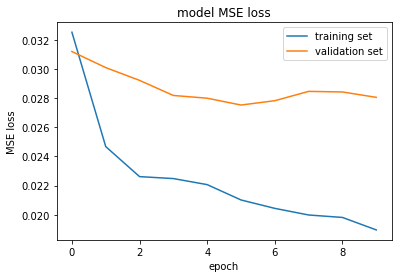

Trained model saved...


In [18]:

checkpointer = ModelCheckpoint(filepath='model.h5', verbose=1, save_best_only=True)

# implement the training process.validate the dataset loss.
history = model.fit_generator(generator(train_samples, batch_size=32), samples_per_epoch = (len(train_samples)//192)*192*6,
                     nb_epoch=10,validation_data=generator(validation_samples, batch_size=32), 
                              nb_val_samples=len(validation_samples)*6,verbose=0, callbacks=[checkpointer])

# Plot cost history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MSE loss')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


print('Trained model saved...')
